In [ ]:
# UMAP script to visualize zircon geochemistry in the Yerington district
#2024-10-03 MAAZ
#2025-06-26, EBL

# input Yerington dataset
# run UMAP
# create decision boundary - linear SVC
# ROC_AUC curve calculation
# Plot global geochemistry in umap


# Importing libraries and functions

In [3]:
import os
import numpy as np
import pandas as pd
import umap
import umap.plot
# import scipy

import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
import plotly.express as px #for plottly
import joblib #for saving UMAP model

from matplotlib import colors

#Machine learning libraries
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score, f1_score

#Advanced plotting libraries
from itertools import compress
from mpl_toolkits.mplot3d import Axes3D
from bokeh.plotting import output_notebook #for interactive plot

#Script requirements
umap.plot.output_notebook() #resources= INLINE
%matplotlib inline
#%matplotlib widget #for 3d plot
sns.set_theme(style='white', context='notebook', rc={'figure.figsize':(14, 10)}) #anything smaller does not help with points

#Helper functions
def export_legend(legend, filepath2, expand=[-5,-5,5,5]):   

    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    
    fig.savefig(filepath2, dpi="figure", bbox_inches=bbox)

def make_dir(destDir):
    image_dir = destDir
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)  

Loading BokehJS ...

In [5]:
#User input
data_folder1 = #SET WD

file1 = "Yerington_test.csv"
file2 = "legend.png" #plot
file3 = "workable_table.xlsx" #for reproducibility
file4 = "standard_scaler.sav"
file5 = "umap_model.sav" 

trial_name = 'UMAP-PCD-YER' #IMPORTANT: change this name to avoid overwriting outputs


#Script begins

os.chdir(data_folder1)
print(data_folder1)

data_folder2 = os.path.join(os.path.dirname(data_folder1), 'figure_outputs', trial_name)
make_dir(data_folder2)


filepath1 = os.path.join(data_folder1, file1)
filepath2 = os.path.join(data_folder2, file2)
filepath3 = os.path.join(data_folder2, file3)
filepath4 = os.path.join(data_folder2, file4)
filepath5 = os.path.join(data_folder2, file5)

#Load table (the column indexes below can be obtained from a data dictionary)
table1 = pd.read_csv(filepath1, low_memory=False)
table1.head()

range_imputed = list([3,8,9,10,11,63])
#range_imputed.extend(list([65, 66, 67, 68, 69, 72, 74, 75, 76, 77]))
#range_imputed.extend(range(65, 77)) #imputed REE

range_imputed.extend(list([85,90,19,97,98,89,27,70,69,99]))

#Generating workable table
table2 = table1.iloc[:, range_imputed] 

#medicine 1
idx1 = table2.Temporality.isnull()
idx2 = table2["Reference"].isnull()
idx3 = table2["Unit"].isnull()
idx4 = table2["ID"].isnull()
idx5 = table2["Sample"].isnull()
idx8 = table2["Zr_Age_Ma"].isnull()


table2.loc[idx1, "Temporality"] = 'Unknown'
table2.loc[idx2, "Reference"] = 'Unknown'
table2.loc[idx3, "Unit"] = 'Unknown'
table2.loc[idx4, "ID"] = 'Unknown'
table2.loc[idx5, "Sample"] = 'Unknown'
table2.loc[idx8, "Zr_Age_Ma"] = 0

#Dropping rows with empty cells

#medicine 2: do not drop string NAs
any_idx = table2.isna().any(axis=1)
table3 = table2.loc[np.invert(any_idx), :] # np.invert(any_idx)
table3.reset_index(inplace = True) #the index from the input table is preserved (for searching points)

data_start_idx =7 #10
col_names = list(table3.columns)
a = table2.shape[0]
b = table3.shape[0]
c = col_names[data_start_idx:]

print(f"Table 2 has {a} rows and Table 3 without NA has {b} rows")
print(f"UMAP will use: {c}")
table3.head()


C:\Users\n11554070\OneDrive - Queensland University of Technology\Documents\Zircon Geochemistry DB\Test Script 2\Yerington\trials
Table 2 has 4712 rows and Table 3 without NA has 4592 rows
UMAP will use: ['Eu/Eu*', 'λ3', 'P', 'Dy/Yb', 'Ce/Nd', 'λ2', 'Eu', 'Imputed_Tb', 'Imputed_Gd', 'Gd/Yb']


,index,Reference,Unit,Temporality,ID,Sample,Zr_Age_Ma,Eu/Eu*,λ3,P,Dy/Yb,Ce/Nd,λ2,Eu,Imputed_Tb,Imputed_Gd,Gd/Yb
0,0,Carter et al. 2022,Porphyry dyke,Syn Mineral,AC22 LC1070,AC22,163.7,0.35990,-148.886920,160.0,0.278163,14.437500,-96.605406,0.526,2.97,9.34,0.080936
1,1,Carter et al. 2022,Porphyry dyke,Syn Mineral,AC22 LC1074,AC22,149.3,0.65225,-97.186755,165.0,0.311261,2.547525,45.447549,3.460,7.00,26.10,0.110080
2,2,Carter et al. 2022,Porphyry dyke,Syn Mineral,AC22 LC1493,AC22,187.8,0.38006,-68.756454,166.0,0.232436,15.876404,-80.450349,0.543,3.22,9.97,0.058372
3,3,Carter et al. 2022,Porphyry dyke,Syn Mineral,AC22 LC1494,AC22,178.2,0.38643,-121.673804,193.0,0.293985,11.769841,-89.796866,0.700,3.31,11.50,0.086466
4,4,Carter et al. 2022,Porphyry dyke,Syn Mineral,AC25 LC0960,AC25,201.6,0.28009,36.218134,205.0,0.274510,5.649805,-91.134002,0.990,8.12,23.80,0.066667


## Printing populations for each category

In [7]:
categoricals = ["Reference", "Unit", "Temporality", "ID","Sample", "Zr_Age_Ma"]
for i in range(len(categoricals)):
    temp = table3.loc[:, [categoricals[i]]].value_counts()
    print(temp)

#table3.loc[:, [categoricals[1]]].value_counts()

Reference                       
Castellanos-Melendez et al. 2024    2319
Carter et al. 2022                  2273
Name: count, dtype: int64
Unit                     
Porphyry dyke                1097
Porphyry dike                1087
Aplite dyke                   382
Luhr Hill                     337
McLeod Hill                   202
Bear                          187
LHG deep                      136
LHG upper                     136
Gabbroic Lens                 136
Fulstone volcanics            135
Fulstone Spring Volcanics     130
Artesia Lake Volcanics        110
Bear QM inner                 110
Border Bear                   105
McLeod QMD inner               85
LHG dyke                       76
Bear QM outer                  72
McLeod QMD outer               38
Artesia Lake volcanics         25
Artesia volcanics               6
Name: count, dtype: int64
Temporality
Syn Mineral    3516
Pre Mineral    1076
Name: count, dtype: int64
ID            
9                 48
13           

# Embedding space
### Run only once each time the notebook is opened. The stochastic process within UMAP wont repeat itself for all plots otherwise

Generating and saving model

In [59]:
try:
    del embedding
except:
    print('Processing for the first time')

components_output = 2 #default=2, dimensionality
neighbors_input = 15 #default=15, preservation of local (> singletons) vs global structure
min_dist_input = 0.003 #0.003, min. dist. of packing value (in low dimensional representation)

#data
data = table3.iloc[:, data_start_idx:].values
sc = StandardScaler()
scaled_data = sc.fit_transform(data) 
#print("Scaler mean: ", sc.mean_)
#print("Scaler scale: ", sc.scale_)

#umap object () for umap.plot
embedding = umap.UMAP(n_neighbors= neighbors_input,
                      min_dist= min_dist_input,
                      metric='correlation', 
                      n_components= components_output,
                     ).fit(scaled_data)  
#requires .embedding_ for getting x, y
#apply transform with: fitter.transform (designed for much less testing new data)

#Saving data for reproducibility
table3.to_excel(filepath3, index=False) #processed table
joblib.dump(sc, filepath4) #scaler
joblib.dump(embedding, filepath5) #umap transform

['C:\\Users\\n11554070\\OneDrive - Queensland University of Technology\\Documents\\Zircon Geochemistry DB\\figure_outputs\\jul15_YER_trials_r2_2\\umap_model.sav']

### Loading model and workable table from previous session

In [13]:
sc = joblib.load(filepath4) #scaler
embedding = joblib.load(filepath5) #umap transformation

embedding2 = embedding.embedding_

#Load table 
table3 = pd.read_excel(filepath3)
table3.tail()

,index,Reference,Unit,Temporality,ID,Sample,Zr_Age_Ma,Eu/Eu*,λ3,P,Dy/Yb,Ce/Nd,λ2,Eu,Imputed_Tb,Imputed_Gd,Gd/Yb
4587,4707,Castellanos-Melendez et al. 2024,Artesia Lake volcanics,Pre Mineral,30,YN25,163.0,0.370738,-98.952678,195.9,0.269493,8.305085,-51.836326,0.992,5.03,17.19,0.083772
4588,4708,Castellanos-Melendez et al. 2024,Artesia Lake volcanics,Pre Mineral,30,YN25,163.9,0.303125,-66.605798,213.9,0.262000,9.800000,-51.534149,1.062,6.70,21.56,0.071867
4589,4709,Castellanos-Melendez et al. 2024,Artesia Lake volcanics,Pre Mineral,32,YN25,157.9,0.264841,-98.505886,319.1,0.366416,4.305036,-96.126845,2.100,13.90,49.30,0.123559
4590,4710,Castellanos-Melendez et al. 2024,Artesia Lake volcanics,Pre Mineral,33,YN25,140.6,0.873888,-364.621227,717.0,0.423951,1.622353,-114.885851,10.230,19.22,64.80,0.160000
4591,4711,Castellanos-Melendez et al. 2024,Artesia Lake volcanics,Pre Mineral,34,YN25,165.9,0.263839,-126.286586,144.9,0.311104,4.388170,-56.287728,1.494,9.37,32.74,0.101551


## Choosing colour mapping

### Option 1: use categorical variable

In [15]:
variable_legend = "Temporality" #e.g., Temporality, ml_classes

#medicine 3
if variable_legend == "Deposit/Batholith":
    variable_legend1 = "Deposit-Batholith"
else:
    variable_legend1 = variable_legend

list_unique = table3[variable_legend].unique()
n_classes = len(list_unique)

#colourmap
mapping = {item:i for i, item in enumerate(list_unique)}
classif= table3[variable_legend].apply(lambda x: mapping[x]) #categorical array (same size as table3)
colourmap = sns.color_palette(palette= cc.glasbey_category10, n_colors = n_classes)
colours = [sns.color_palette(palette= colourmap)[x] for x in classif] #RGB triplets

colourmap_updated = colourmap #pre-allocating
for x in range(0, n_classes):
    
    idx = (classif == x)
    name = list_unique[x]

    colours_sub = colourmap[x]
    
    if name == 'Ore syn-mineral magmatism':
        colours_sub = colors.to_rgb('red')

    if name == 'Syn Mineral':
        colours_sub = colors.to_rgb('red')

    if name == 'Ore related magmatism':
        target_colour = (255, 208, 0)
        colours_sub = tuple(ti/255 for ti in target_colour)

    if name == 'Unknown':
        colours_sub = colors.to_rgb('lightgrey')

    if name == 'S Type Granite':
        colours_sub = colors.to_rgb('violet')

    colourmap_updated[x] = colours_sub

### Supervised learning (preliminary binary classification without grid search)

In [17]:
variable_legend = "Temporality" #Temporality

#medicine 3
if variable_legend == "Deposit/Batholith":
    variable_legend1 = "Deposit-Batholith"
else:
    variable_legend1 = variable_legend
    

list_unique = table3[variable_legend].unique()
n_classes = len(list_unique)

#colourmap
mapping = {item:i for i, item in enumerate(list_unique)}
classif= table3[variable_legend].apply(lambda x: mapping[x]) #categorical array (same size as table3)

#panda series
df = pd.DataFrame( dict(x=embedding2[:,0], y=embedding2[:,1], z= classif) ) 
X = df.iloc[:, 0:2].to_numpy()
Y = df.iloc[:, 2].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

In [19]:
# binary decision plane using linear SVC, performance scores of binary model

clf = SVC(kernel="linear", C=0.025, random_state=42, probability= True) #C = 1 (regularisation)

clf.fit(X_train, y_train)
# score = clf.score(X_test, y_test) #mean accuracy 

 # Predict using the best model
best_model = clf #if cross-validation: .best_estimator_
pred = best_model.predict(X_test)
ac = balanced_accuracy_score(y_test, pred) # same as 'score'
f1_ = f1_score(y_test, pred) # F1 scores

# Receiver operating characteristic (ROC) area under the curve (AUC)
probs = best_model.predict_proba(X_test)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc_ = auc(fpr, tpr)

print("=== Nested K-Fold Cross-Validation Scores ===")
print("Mean balanced accuracy: "+ str(round(np.mean(ac), 3)))
print("Mean F1: "+ str(round(np.mean(f1_), 3)))
print("Mean roc_auc: "+ str(round(np.mean(auc_), 3)))


=== Nested K-Fold Cross-Validation Scores ===
Mean balanced accuracy: 0.5
Mean F1: 0.0
Mean roc_auc: 0.795


### Plotting selected variable

C:\Users\n11554070\OneDrive - Queensland University of Technology\Documents\Zircon Geochemistry DB\Test Script 2\Yerington\figure_outputs\UMAP-PCD-YER\Temporality_plot.png


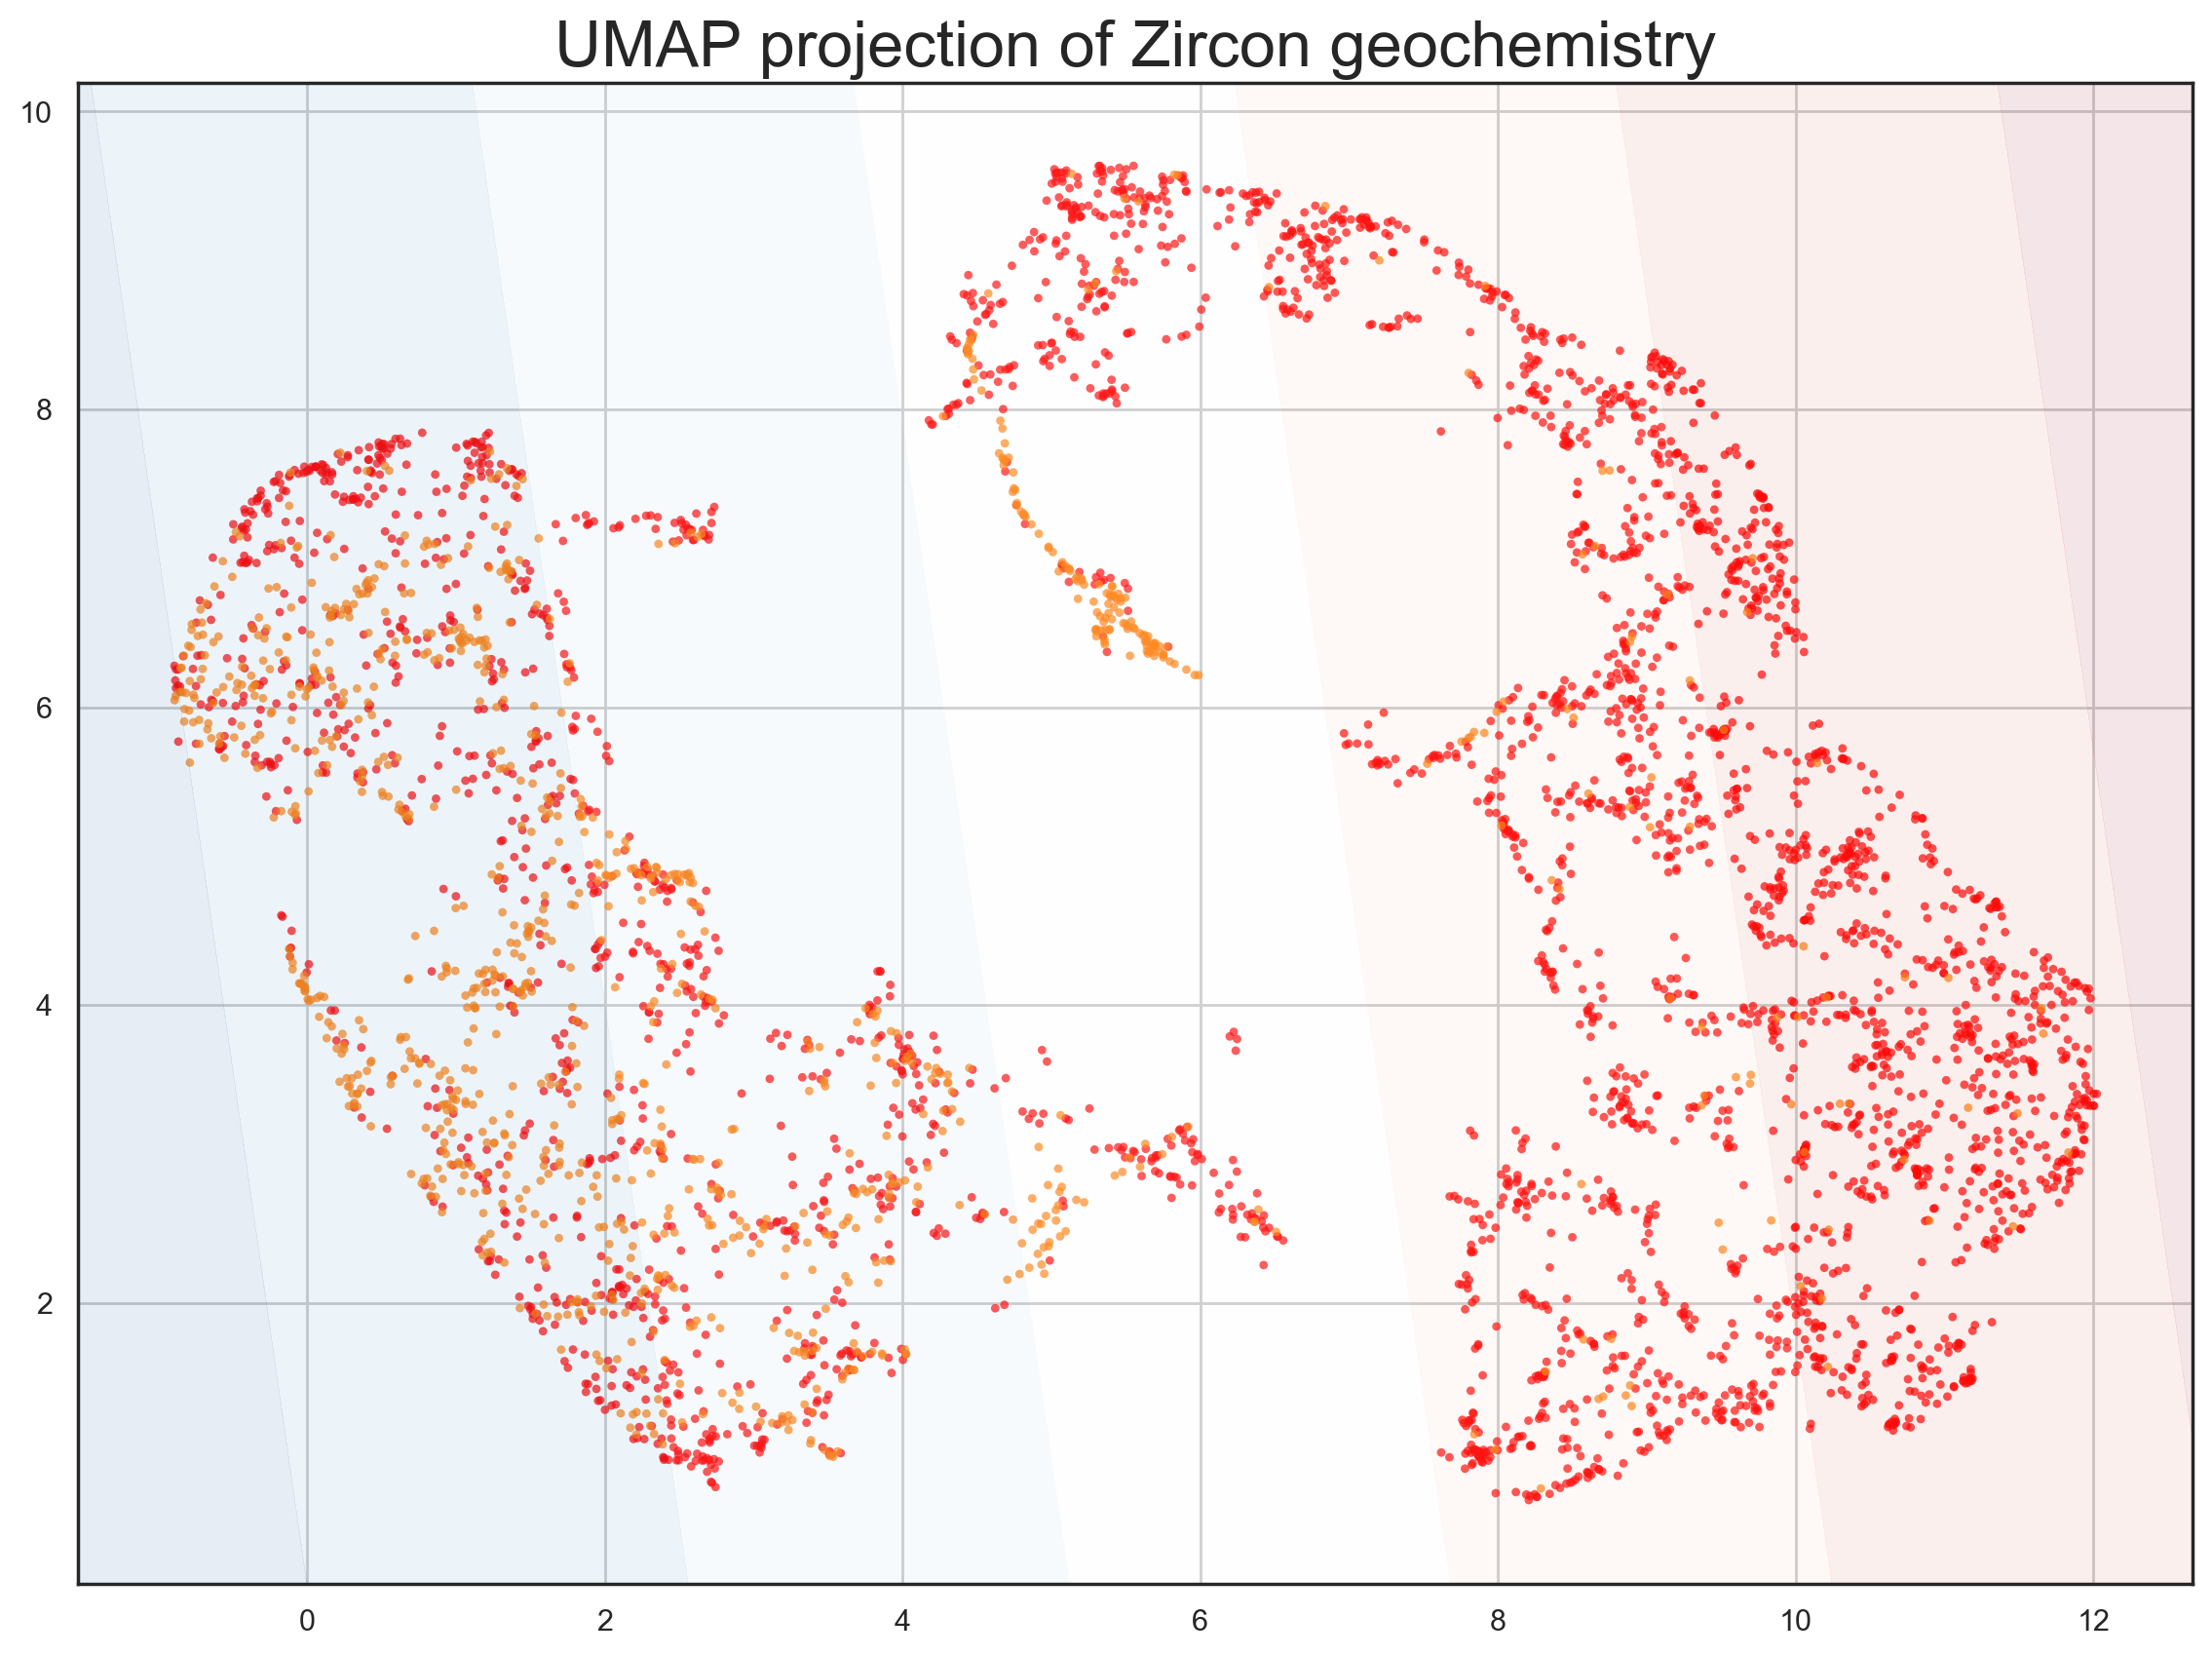

In [21]:

#Saving names
filepath3_new = filepath2.replace("legend.png", variable_legend1 + "_legend.png")
filepath4_new = filepath2.replace("legend.png", variable_legend1 + "_plot.png")
print(filepath4_new)

#Plot
markerSize = 10
fontSize = 18

fig = plt.figure(dpi= 200) #1200 , figsize=(10, 10)

for x in range(0, n_classes):
    
    idx = (classif == x)
    name = list_unique[x]
   
    # colours_sub = list(compress(colours, idx)) #required to index list
    colours_sub = np.asarray(colourmap_updated[x]).reshape(1,-1)        

    scatter = plt.scatter(embedding2[idx, 0], embedding2[idx, 1],
                              
                              c=colours_sub, label = name,
                              s= markerSize, alpha= .7, edgecolors= 'none')

# #Wiggles (new plots)
plt.autoscale(False)
# # plt.plot(xx, yy, 'k-') #linear
# plt.contour(xx, yy, Z, cmap=plt.cm.Paired) #multi-class

#Generic
ax = plt.gca()
cm = plt.cm.RdBu

#Try this 3 options (commenting them if either of them fail)
#DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.1, ax=ax, eps=.5, response_method='predict') #area with colours following predicted classes (if ignoring 'cm')

DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, plot_method='contourf',  alpha=0.1, ax=ax, response_method="decision_function") #include decision boundary and margins (for SVC)
#DecisionBoundaryDisplay.from_estimator(clf, X, plot_method='pcolormesh', ax=ax, alpha=0.3) #as image

#Settings
plt.grid(True)
plt.gca().set_aspect('equal', 'datalim')

plt.title('UMAP projection of Zircon geochemistry', fontsize=24)

lgnd = plt.legend(ncol=1, fontsize= fontSize, loc='center right', bbox_to_anchor=(1.4, 0.5),
                  markerscale= 10, scatterpoints=1)
export_legend(lgnd, filepath2= filepath3_new)
lgnd.remove()
plt.show()

fig.savefig(filepath4_new, dpi="figure")
            